# E2a: Küchentischversuch zum Laval-Rotor

Name: Martin Kroeker 
Datum: 03.01.2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Mit welchen Frequenzen vibriert mein Handy?
Welchem Zweck dient das Interpolieren?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="bild_phone.JPG" width="500">

- Beschreibung des Aufbaus: 
Der Aufbau der Versuches besteht aus einem Handy (Samsung Galaxy S10e), auf dem mit Tesafilm ein Schwingungssensor angebracht ist. Diese ist an den Rasberry Pi angeschlossen.


- Vorgangsbeschreibung:
Zu Beginn des Versuches wird mit dem Befehl i2cdetect -y 1 im Terminal des Rasberries geprüft, ob der Beschleuningungssensor richtig angeschlossen wurde. Danach wird ein Vibrationsalarm auf dem Handy eingestellt. Nun wird acceleration_measurement.py mit Angabe des Phone-Setup-Pfades ausgeführt.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [15]:
import h5py
import numpy as np
import json
import os

#matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [16]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20240104_162004_MartinKroeker_phone"
h5_file_name = "data_20240104_162004_MartinKroeker_phone.h5"
# ---------------------------------------------------------------------------------------------#1-end

In [17]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240104_162004_MartinKroeker_phone/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240104_162004_MartinKroeker_phone/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240104_162004_MartinKroeker_phone/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eea96cf-4970-6bbf-a558-18c3e0a0b5f5": {
    "type": "probe",
    "name": "phone",
    "comment": "",
    "path": "measurement_data/dat

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [18]:




with h5py.File(path_measurement_folder+"/"+h5_file_name, 'r') as hdf_file:
    # Access the group for the sensor ID
    sensor_group = hdf_file[sensor_settings_dict["ID"]]

    # Read acceleration data into NumPy arrays
    acceleration_x = np.array(sensor_group["acceleration_x"])
    acceleration_y = np.array(sensor_group["acceleration_y"])
    acceleration_z = np.array(sensor_group["acceleration_z"])
    
    # Read timestmap data into NumPy arrays
    timestamp = np.array(sensor_group["timestamp"])

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [19]:
#Use the predifined function get_vec_accel
data_raw = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
mean = np.mean(data_raw)
data = data_raw - mean

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

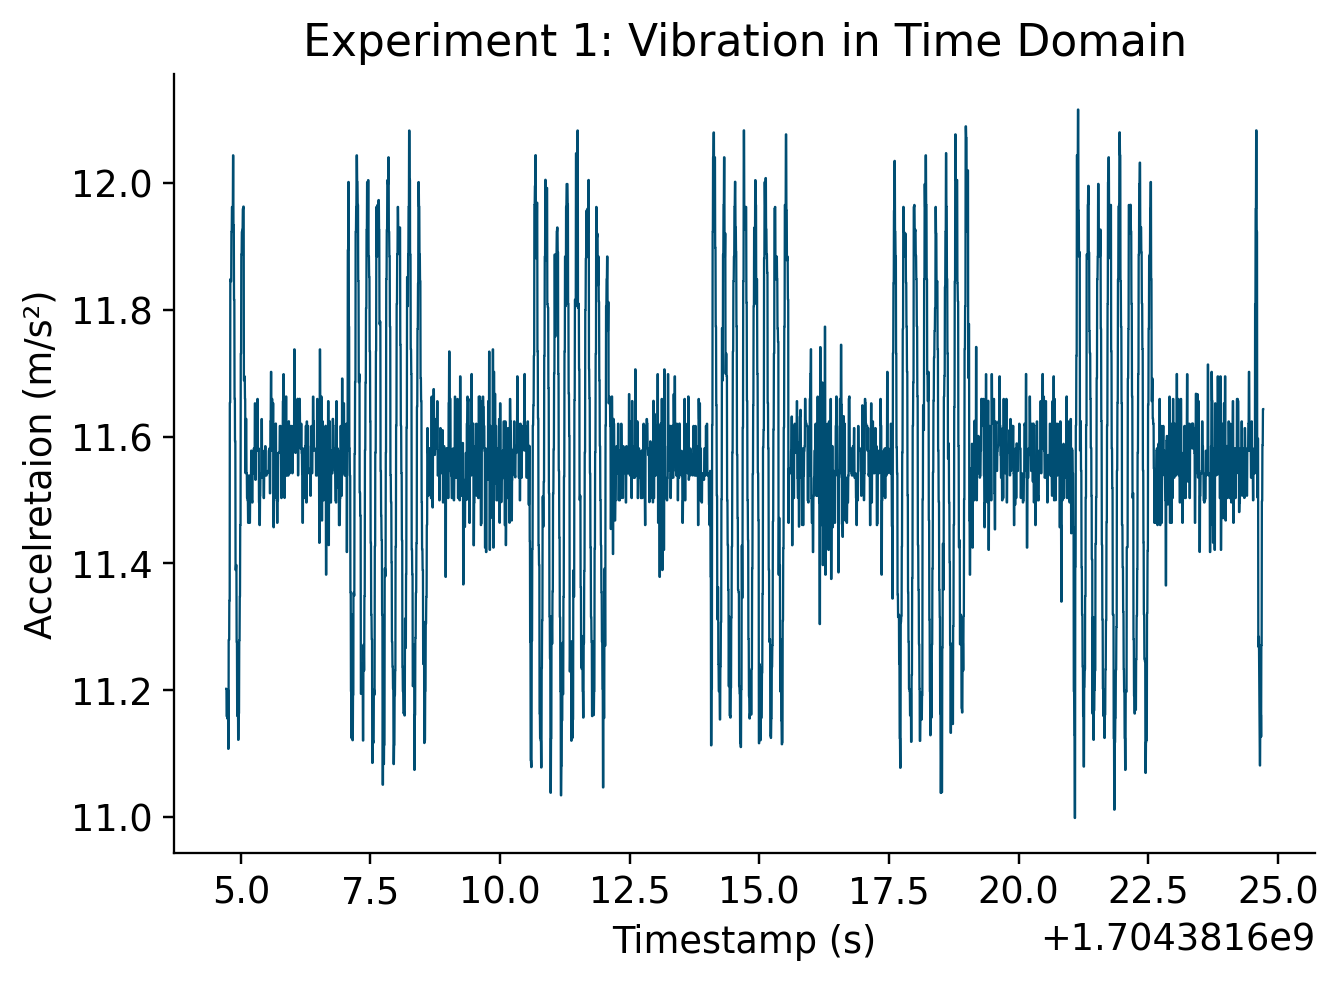

In [20]:
#plot data
plt.plot(timestamp, data_raw)
plt.title("Experiment 1: Vibration in Time Domain")
plt.xlabel("Timestamp (s)")
plt.ylabel("Accelretaion (m/s²)")
plt.show()

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [21]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
interpol_data = interpolation(timestamp, data)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

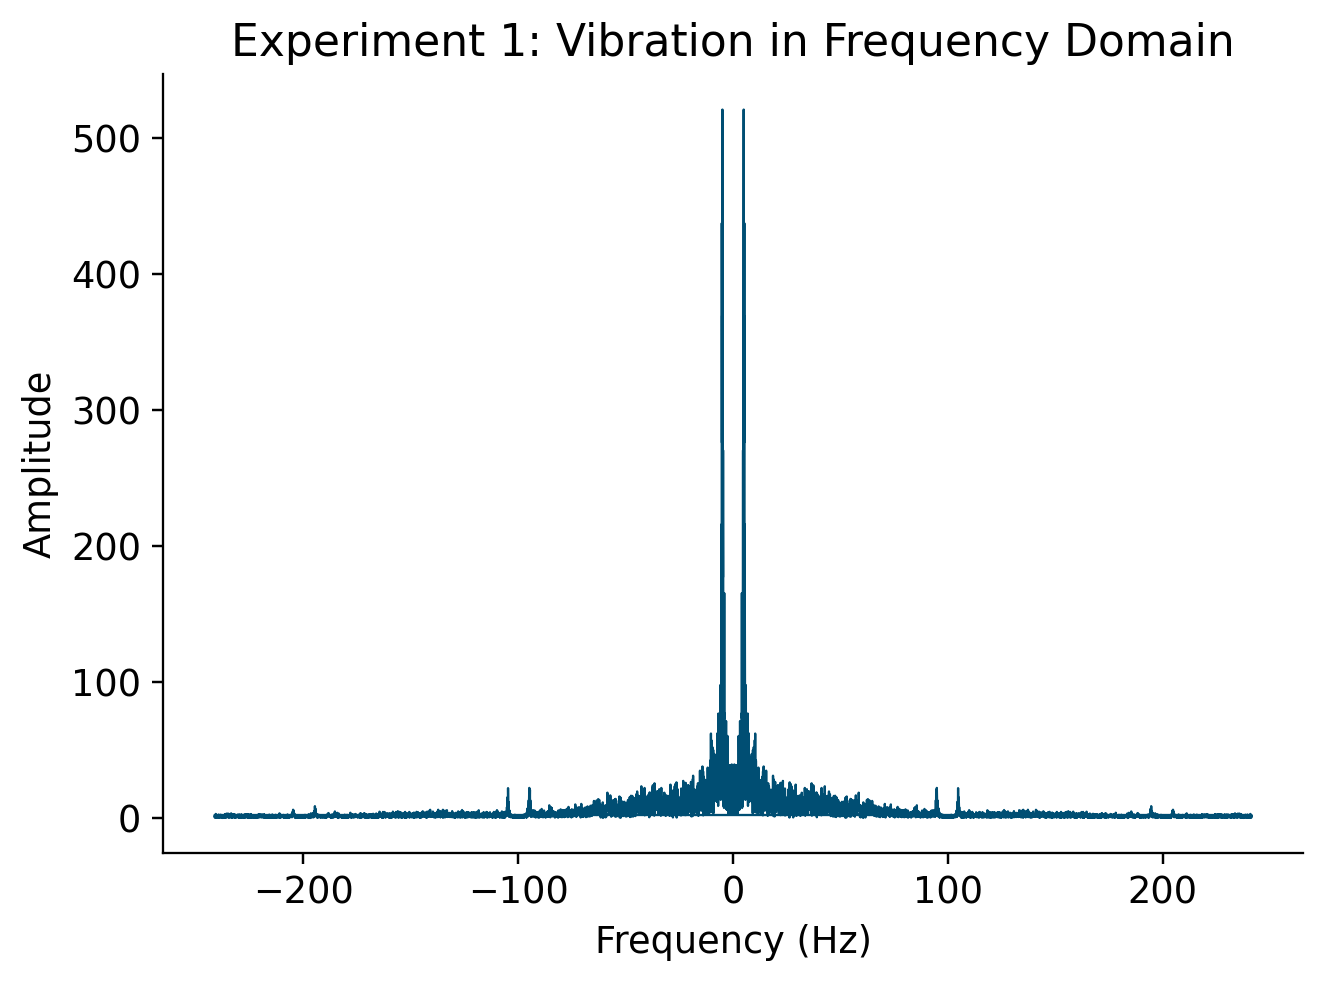

In [22]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
#FFT
frequency_domain_data = my_fft(interpol_data[1], interpol_data[0])

#plot data
plt.figure()
plt.plot(frequency_domain_data[1], frequency_domain_data[0])
plt.title("Experiment 1: Vibration in Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="bild_waschmaschine.JPG" width="500">

- Beschreibung des Aufbaus: 
Der Aufbau der Versuches besteht der hauseigenen Waschmaschine der WG sowie einem Rasberry Pie, einem Beschleunigungssensor und etwas Tesafilm. Die auf dem Bild zu sehenden Waschmittel-Pods gehören nicht zum Versuchsaufbau.
Der Beschleunigungssensor ist mit Tesafilm auf der Waschmaschine befestigt und an den Rasberry angeschlossen.


- Vorgangsbeschreibung: 
Zu Beginn des Versuches wird mit dem Befehl i2cdetect -y 1 im Terminal des Rasberries geprüft, ob der Beschleuningungssensor richtig angeschlossen wurde. Dann wird wird gewartet bis die, vom Assisten zwei Stunden zuvor einschaltete Waschmaschine den Schleudergang einlegt. Nun wird acceleration_measurement.py mit Angabe des Waschmaschinen-Setup_Pfades ausgeführt.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [23]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20240102_171259_MartinKroeker_waschmaschine"
h5_file_name = "data_20240102_171259_MartinKroeker_waschmaschine.h5"

"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": ""
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": ""
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": ""
  },
  "1eea9876-33a7-6273-b74a-a038f430ee55": {
    "type": "probe",
    "name": "waschmaschine",
    "comment": ""
  }
}
{
  "ID": "1ee847be-fddd-6ee4-892a-68c4555b0981",
  "name": "accelerometer",
  "range_min": -2,
  "range_max": 2,
  "frequency": 800
}
Probe: waschmaschine


#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [24]:
with h5py.File(path_measurement_folder+"/"+h5_file_name, 'r') as hdf_file:
    # Access the group for the sensor ID
    sensor_group = hdf_file[sensor_settings_dict["ID"]]

    # Read acceleration data into NumPy arrays
    acceleration_x = np.array(sensor_group["acceleration_x"])
    acceleration_y = np.array(sensor_group["acceleration_y"])
    acceleration_z = np.array(sensor_group["acceleration_z"])
    

#### 2. Betrag der Beschleunigung berechnen


In [25]:
#Use the predifined function get_vec_accel
data_raw = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
mean = np.mean(data_raw)
data = data_raw - mean

#adjust the timestamp to the actuall measurement
target_entries = len(data)
timestamp_c = np.linspace(0, 20, target_entries)
#Hier musste ich leider trixen, da bei der ersten Messung dir Zeitpunte nich augenommen wurden. 
#Das erzeugt einen Messfehler da nun die Datenpunkte schon als zeitlich interpoliert angenommen werden.
#Leider macht es, die Messung unbrauchbar, allerdings sollte das Ergebnis für die Frequenzen des Signals
#in der nähe des Tatsächlichen liegen und der Plot sieht trotzdem schön aus.


#### 3. Darstellung der Messdaten

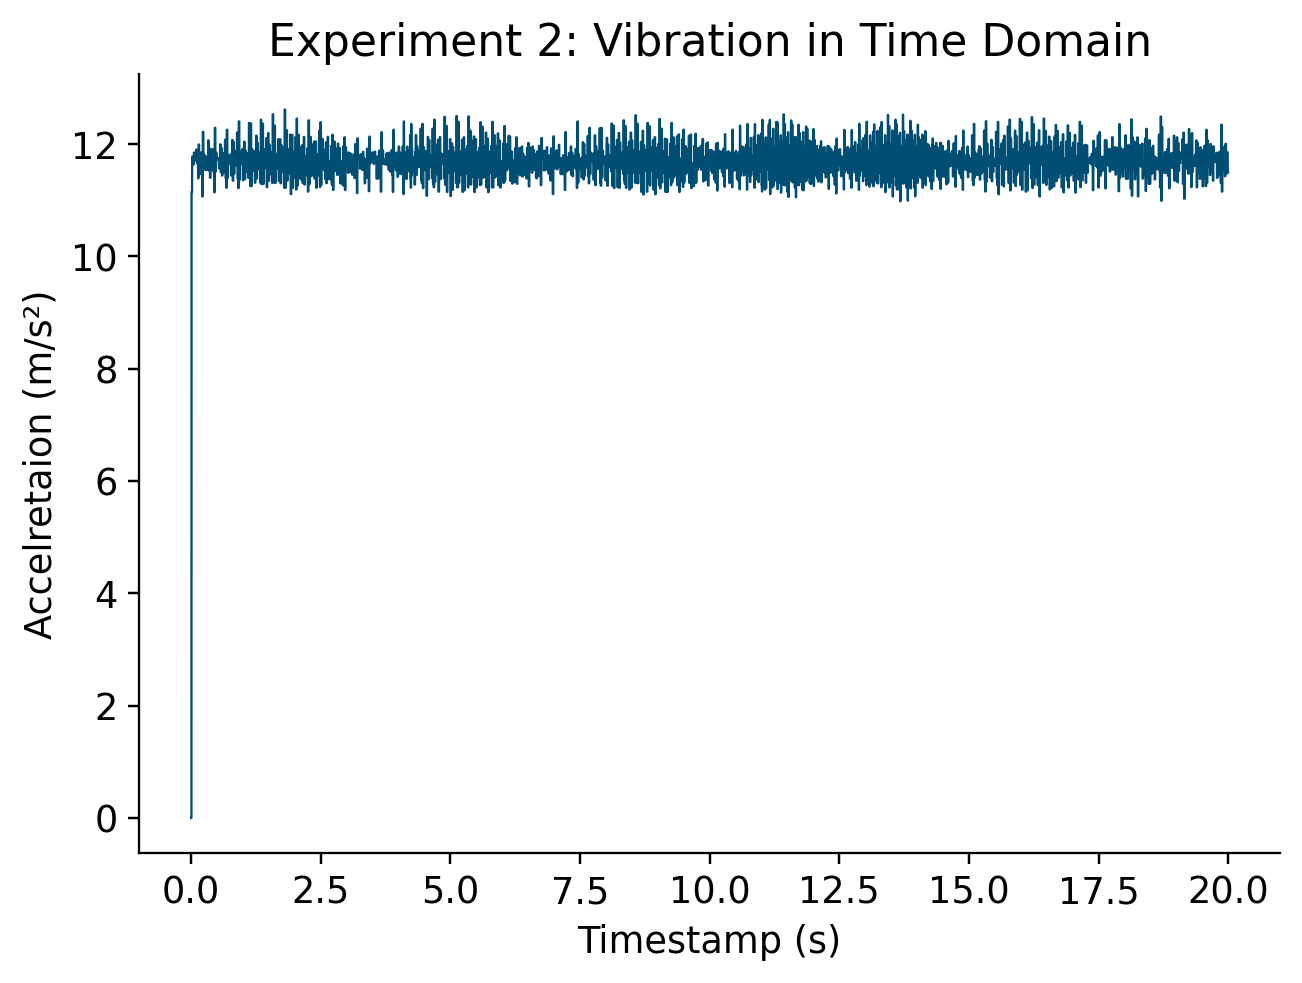

In [26]:
#plot data
plt.plot(timestamp_c, data_raw)
plt.title("Experiment 2: Vibration in Time Domain")
plt.xlabel("Timestamp (s)")
plt.ylabel("Accelretaion (m/s²)")
plt.show()

#### 4. Interpolation der Messwerte



In [27]:
#use implementet funtion interpolation()
interpol_data_2 = interpolation(timestamp_c, data)

#### 5 & 6. FFT durchführen und graphisch darstellen


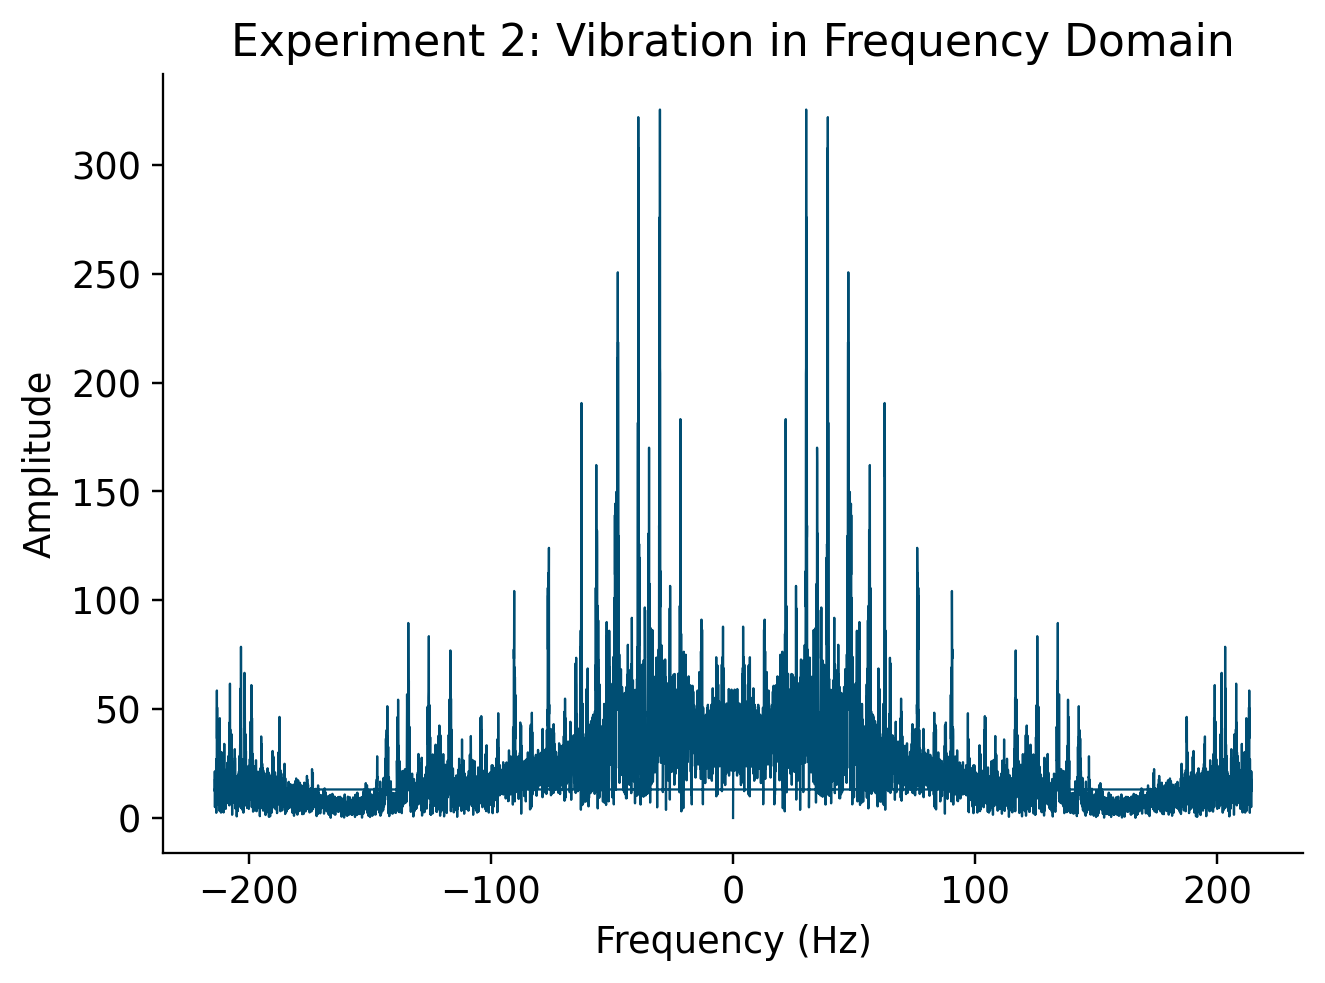

In [28]:
#FFT
frequency_domain_data_2 = my_fft(interpol_data_2[1] ,interpol_data_2[0])

plt.figure()
plt.plot(frequency_domain_data_2[1], frequency_domain_data_2[0])
plt.title("Experiment 2: Vibration in Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

## Diskussion
Zunächst kann man beim ersten Versuch feststellen, dass sich die Vibration eines Handyalarms zum Großteil aus Schwingungen einer Frequenz zusammensetzt. Der Beschleunigungssensor war zu dieser Zeit frei von anderen Einwirkungen als dem Handy, und die aufgenommenen Messdaten wurden interpoliert, bevor die FFT durchgeführt wurde. Das spricht für gute Qualität der Ergebnisse.

Beim zweiten Versuch ist auf die Ergebnisse wenig Verlass, da die Messung der Zeitpunkte, der unterschiedlichen Messpunkte, fehlgeschlagen ist. Da man nicht davon ausgehen kann, dass die Sensoren in hinreichend gleichmäßigem Abstand Beschleunigungswerte aufgenommen haben, um akkurate Frequenzen berechnen zu können. Das zeitliche Verschieben von Messwerten kann die berechneten Frequenzen nicht nur verzerren, sondern grundlegend verändern. Für genauere anschließende Berechnungen sind die Werte dieser FFT also nicht geeignet. Da der Sensor aber sicherlich mit einer gewissen Konsistenz abtastet, lassen sich die Werte immer noch zur Veranschaulichung nutzen.

## Fazit
Bei diesem Versuch ist der Begriff der Interpolation für mich zum ersten Mal aufgetaucht. Grundlegende Vorgehensweisen wie die Fourier-Transformation waren mir natürlich bekannt. Mir ist allerdings klar geworden, dass diese Rechenoperation geringen Wert besitzt, wenn man mit zeitlich inkonsistent aufgenommenen Messwerten arbeitet. Außerdem ist mir, wie schon beim letzten Versuch, aufgefallen, dass NumPy sehr angenehm ist.